# Linear and Ridge Regression

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
from matplotlib import pyplot as plt
%matplotlib inline

### Explore Data

In [2]:
data_train = pd.read_table('Data/crime-train.txt')
data_test = pd.read_table('Data/crime-test.txt')

In [3]:
data_train.head()

,ViolentCrimesPerPop,population,householdsize,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,...,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn
0,0.67,-0.45,-1.85,-1.06,0.67,0.08,-0.85,-0.34,0.68,-0.24,...,-0.23,-0.02,-0.53,-1.08,-0.13,-0.66,-0.41,-0.56,1.26,-0.39
1,0.43,-0.45,-0.27,-0.22,-0.17,-0.34,-0.58,-0.50,-1.57,-0.29,...,-0.23,-0.33,-0.58,0.03,0.22,-0.46,-0.50,-0.11,-0.62,-0.39
2,0.12,-0.14,1.87,0.55,0.04,0.02,-1.19,-0.03,0.68,1.05,...,-0.23,-0.11,-1.51,1.07,0.07,-0.01,-0.41,0.77,0.52,-0.39
3,0.03,-0.38,0.53,-0.28,-0.79,-0.64,-0.35,-0.34,0.46,0.66,...,-0.23,-0.46,0.54,0.58,-0.08,-0.61,-0.23,-0.70,-0.62,-0.39
4,0.14,-0.30,-1.12,-0.74,-0.10,-0.40,-0.30,-0.19,0.68,0.76,...,-0.23,2.10,-0.92,-0.25,0.52,-0.06,-0.50,1.71,-0.27,-0.39


In [4]:
data_train.to_csv('clean_data.csv')

### Useful Functions

In [5]:
def RMSE(y_actual, y_pred):
    return sqrt(((y_actual-y_pred).T @ (y_actual-y_pred))/len(y_actual))

### Generate Design Matrices

In [6]:
def design_matrices(df):
    df['intercept'] = np.ones(len(df))
    X = np.array(df.drop('ViolentCrimesPerPop',axis=1))
    y = np.array(df['ViolentCrimesPerPop'].values.reshape(len(df),1))
    return X,y

In [7]:
X_train, y_train = design_matrices(data_train)
X_test, y_test = design_matrices(data_test)

### 1.) Linear Regression - Closed Form

In [8]:
def linear_regression_closedForm(X,y):
    w = np.linalg.inv(X.T @ X) @ X.T @ y
    return w

In [9]:
# Train model
w_lrCF = linear_regression_closedForm(X_train,y_train)

In [10]:
# Predict crime rates for training data and testing data
lrCF_preds_train = X_train @ w_lrCF
lrCF_preds_test = X_test @ w_lrCF

#### Results

In [11]:
print('Training RMSE: ', RMSE(y_train, lrCF_preds_train))
print('Test RMSE: ', RMSE(y_test,lrCF_preds_test))

Training RMSE:  0.12768967421762195
Test RMSE:  0.14583464490949063


### 2.) Ridge Regression - Closed Form

In [12]:
def ridge_regression_closedForm(X,y,lam):
    w = np.linalg.inv(X.T @ X + lam*np.eye(X.shape[1])) @ X.T @ y
    return w

In [13]:
def k_fold_crossValidation_cf(X,y,k,lam_i):
    errors = {} # Dictionary to store averaged RMSE for different lambda values {lambda: RMSE}
    for i in range(0,10):
        lam = lam_i/(2**i)
        error_temp = []
        for i in range(0,k):
            k_parts_X = np.split(X,k)
            k_parts_y = np.split(y,k)
            Xtest = k_parts_X.pop(i)
            ytest = k_parts_y.pop(i)
            Xtrain = np.concatenate(k_parts_X)
            ytrain = np.concatenate(k_parts_y)
            w_temp = ridge_regression_closedForm(Xtrain,ytrain,lam)

            preds = Xtest @ w_temp
            error_temp.append(RMSE(ytest,preds))
        errors[lam] = np.mean(error_temp)
        
    return min(errors, key=errors.get)

In [14]:
# Find best value for lambda
ideal_lam_lr= k_fold_crossValidation_cf(X_train, y_train,5,400)
print("Optimal lambda: ", ideal_lam_lr)

Optimal lambda:  25.0


In [15]:
# Train model
w_rrCF = ridge_regression_closedForm(X_train, y_train, ideal_lam_lr)

In [16]:
# Predict crime rates for training data and testing data
rrCF_preds_train = X_train @ w_rrCF
rrCF_preds_test = X_test @ w_rrCF

#### Results

In [17]:
print('Training RMSE: ', RMSE(y_train, rrCF_preds_train))
print('Test RMSE: ', RMSE(y_test, rrCF_preds_test))

Training RMSE:  0.12879701459879794
Test RMSE:  0.1457465070705806


### 3.) Linear Regression - Gradient Descent

In [18]:
# Loss Function
def compute_loss_lr(X, y, w): 
    return np.asscalar((X@w - y).T @ (X@w - y))

In [19]:
# Gradient Descent Algorithm
def linear_regression_gradientDescent(X, y, alpha, converge_thresh, ret_lossHistory=False):
    w = np.random.normal(size=(X.shape[1],1))       # initial guess
    loss_history = [compute_loss_lr(X,y,w)]         # Keep track of loss over iterations to ensure it decreasing
    loss_dif = loss_history[0]
    iteration = 0
    
    while loss_dif > converge_thresh:
        w = w + alpha * (X.T @ (y - X @ w))
        loss_history.append(compute_loss_lr(X,y,w))
        loss_dif = loss_history[iteration] - loss_history[iteration+1]
        iteration += 1
        
    if ret_lossHistory:
        return w, loss_history
    else:
        return w

In [20]:
w_lrGD, loss_history = linear_regression_gradientDescent(X_train,y_train,0.00005,converge_thresh=1e-6, ret_lossHistory=True)

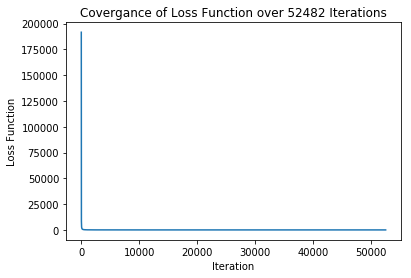

In [21]:
plt.plot(np.linspace(0,len(loss_history)-1,len(loss_history)),loss_history)
plt.title('Covergance of Loss Function over %d Iterations' % (len(loss_history)-1))
plt.xlabel('Iteration')
plt.ylabel('Loss Function');

In [22]:
# Predict crime rates for training data and testing data
lrGD_preds_train = X_train @ w_lrGD
lrGD_preds_test = X_test @ w_lrGD

#### Results

In [23]:
print('Training RMSE: ', RMSE(y_train, lrGD_preds_train))
print('Test RMSE: ', RMSE(y_test,lrGD_preds_test))

Training RMSE:  0.12771102875017526
Test RMSE:  0.14566827074850322


### 4.) Ridge Regression - Gradient Descent

In [24]:
# Loss Function
def compute_loss_rr(X, y, w, lam):
    return np.asscalar((X@w - y).T @ (X@w - y) + lam*(w.T@w))

In [25]:
# Gradient Descent Algorithm
def ridge_regression_gradientDescent(X, y, lam, alpha, converge_thresh, ret_lossHistory=False):
    w = np.random.normal(size=(X.shape[1],1))           # initial guess
    loss_history = [compute_loss_rr(X,y,w,lam)]         # Keep track of loss over iterations to ensure it decreasing
    loss_dif = loss_history[0]
    iteration = 0
    
    while loss_dif > converge_thresh:
        w = w + alpha * ((X.T @ (y - X @ w)) - lam*w)
        loss_history.append(compute_loss_rr(X,y,w,lam))
        loss_dif = loss_history[iteration] - loss_history[iteration+1]
        iteration += 1
        
    if ret_lossHistory:
        return w, loss_history
    else:
        return w

In [26]:
def k_fold_crossValidation_gd(X,y,k,lam_i):
    errors = {} # Dictionary to store averaged RMSE for different lambda values {lambda: RMSE}
    for i in range(0,10):
        lam = lam_i/(2**i)
        error_temp = []
        for i in range(0,k):
            k_parts_X = np.split(X,k)
            k_parts_y = np.split(y,k)
            Xtest = k_parts_X.pop(i)
            ytest = k_parts_y.pop(i)
            X_temp = np.concatenate(k_parts_X)
            y_temp = np.concatenate(k_parts_y)
            w_temp = ridge_regression_gradientDescent(X_temp,y_temp,lam,0.00005,1e-5)

            preds = Xtest @ w_temp
            error_temp.append(RMSE(ytest,preds))
        errors[lam] = np.mean(error_temp)
        
    return min(errors, key=errors.get)

In [27]:
ideal_lam_rr = k_fold_crossValidation_gd(X_train,y_train,5,400)
print("Optimal lambda: ", ideal_lam_rr)

Optimal lambda:  25.0


In [28]:
w_rrGD, loss_history_rr = ridge_regression_gradientDescent(X_train,y_train,ideal_lam_rr,0.00005,1e-6,ret_lossHistory=True)

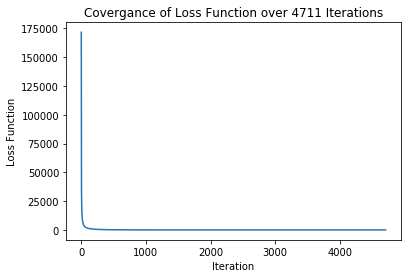

In [29]:
plt.plot(np.linspace(0,len(loss_history_rr)-1,len(loss_history_rr)),loss_history_rr)
plt.title('Covergance of Loss Function over %d Iterations' % (len(loss_history_rr)-1))
plt.xlabel('Iteration')
plt.ylabel('Loss Function');

In [30]:
# Predict crime rates for training data and testing data
rrGD_preds_train = X_train @ w_rrGD
rrGD_preds_test = X_test @ w_rrGD

#### Results

In [31]:
print('Training RMSE: ', RMSE(y_train, rrGD_preds_train))
print('Test RMSE: ', RMSE(y_test,rrGD_preds_test))

Training RMSE:  0.12879821380006942
Test RMSE:  0.14575250910333068


### Overall Result Comparison

#### Linear Regression

In [32]:
# Closed Form
print('Training RMSE: ', RMSE(y_train, lrCF_preds_train))
print('Test RMSE: ', RMSE(y_test,lrCF_preds_test))

Training RMSE:  0.12768967421762195
Test RMSE:  0.14583464490949063


In [33]:
# Gradient Descent
print('Training RMSE: ', RMSE(y_train, lrGD_preds_train))
print('Test RMSE: ', RMSE(y_test,lrGD_preds_test))

Training RMSE:  0.12771102875017526
Test RMSE:  0.14566827074850322


#### Ridge Regression

In [34]:
# Closed Form
print('Training RMSE: ', RMSE(y_train, rrCF_preds_train))
print('Test RMSE: ', RMSE(y_test, rrCF_preds_test))

Training RMSE:  0.12879701459879794
Test RMSE:  0.1457465070705806


In [35]:
# Gradient Descent
print('Training RMSE: ', RMSE(y_train, rrGD_preds_train))
print('Test RMSE: ', RMSE(y_test, rrGD_preds_test))

Training RMSE:  0.12879821380006942
Test RMSE:  0.14575250910333068
